# Diabetes Analysis with Cross-Validation and Hyperparameter Tuning
This notebook demonstrates how to perform cross-validation and hyperparameter tuning on a diabetes dataset using scikit-learn. We use Decision Tree and Logistic Regression models, evaluate with stratified cross-validation, tune hyperparameters with GridSearchCV, and assess performance on a held-out test set with multiple metrics and ROC curves.

The code is organized into modular cells for clarity and robustness.

In [44]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay,
    accuracy_score,
    f1_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
DEFAULT_DATA_PATH = '../data/diabetes_prediction_dataset.csv'


In [45]:
# Data handling
class PatientDataset:
    """
    Utility to load and preprocess a typical diabetes dataset.
    Assumes a binary target column named 'Outcome'.
    """
    def __init__(self, data_path: str = DEFAULT_DATA_PATH, random_state: int = RANDOM_STATE):
        self.path = data_path
        self.data = pd.read_csv(self.path)
        self.random_state = random_state

    def preprocess(self, target_col: str = 'Outcome'):
        """
        Basic, robust preprocessing suitable for tabular numeric data:
        - Drops duplicate rows
        - Splits into X (features) and y (target)
        - Returns X, y, and a ColumnTransformer that imputes numeric features
        """
        df = self.data.copy()
        # Basic cleanup
        df = df.drop_duplicates().reset_index(drop=True)
        if target_col not in df.columns:
            raise ValueError(f"Target column '{target_col}' not found in data. Columns: {list(df.columns)}")

        y = df[target_col].astype(int)
        X = df.drop(columns=[target_col])

        # Identify numeric columns (typical for diabetes dataset)
        num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
        # Fallback if none detected
        if not num_cols:
            raise ValueError("No numeric feature columns found for preprocessing.")

        # Impute numerical features with median; scaling will be applied in specific pipelines
        preprocessor = ColumnTransformer(
            transformers=[
                ('num_imputer', SimpleImputer(strategy='median'), num_cols)
            ],
            remainder='drop'
        )
        return X, y, preprocessor


Data shape: (100000, 9)

Dtypes:
gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

Missing values per column:
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

Numeric summary (describe):
                 age  hypertension  heart_disease            bmi  \
count  100000.000000  100000.00000  100000.000000  100000.000000   
mean       41.885856       0.07485       0.039420      27.320767   
std        22.516840       0.26315       0.194593       6.636783   
min         0.080000       0.00000       0.000000      10.010000   
25%        24.000000       0.00000     

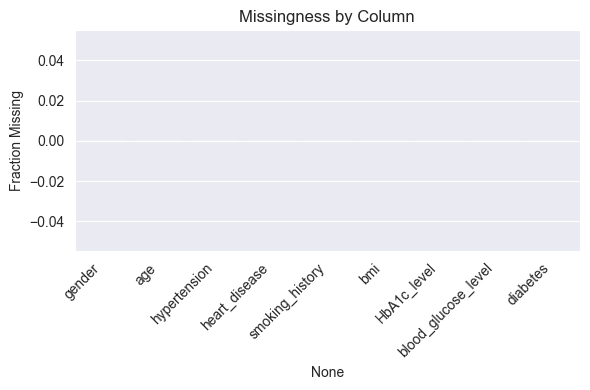

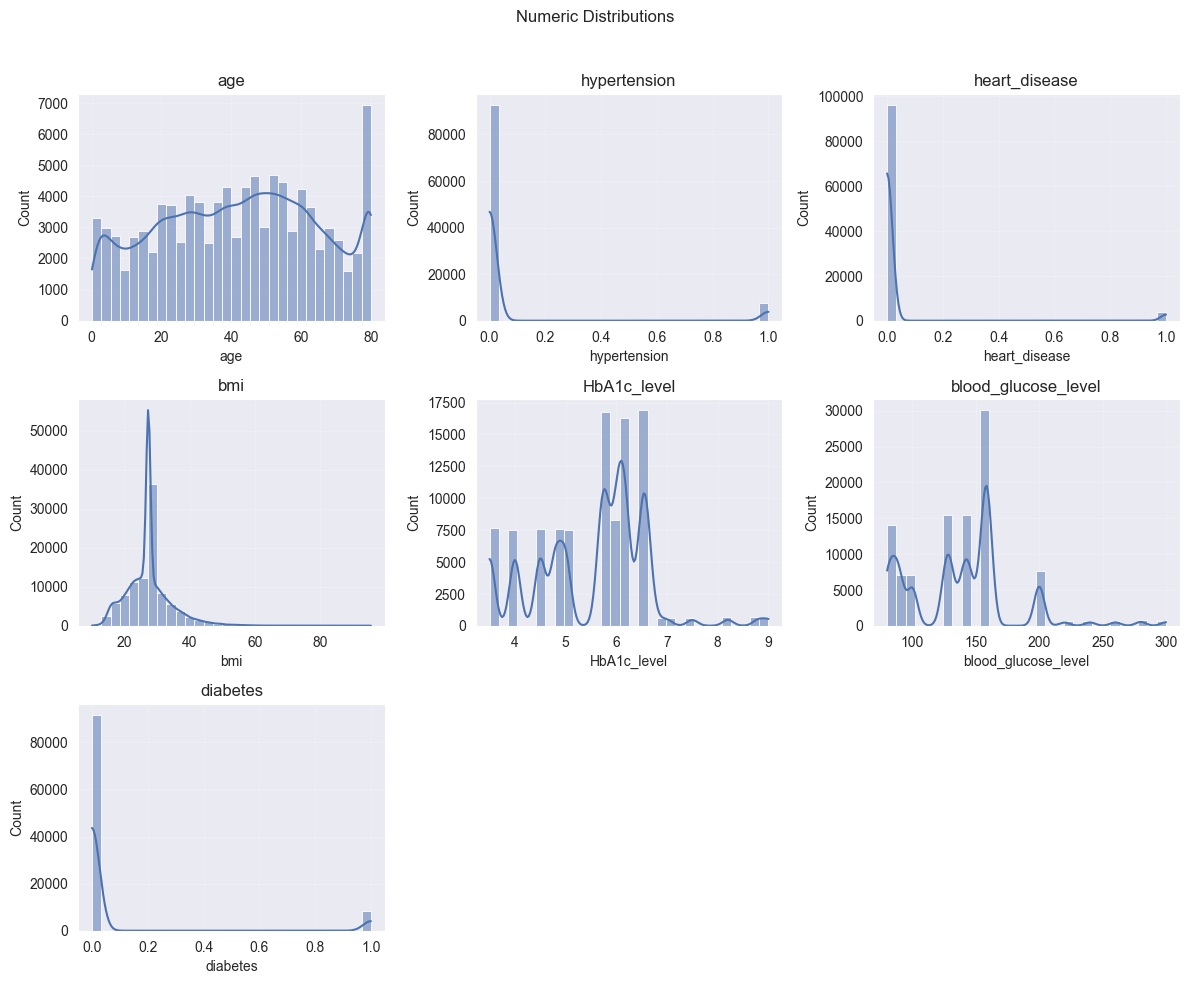

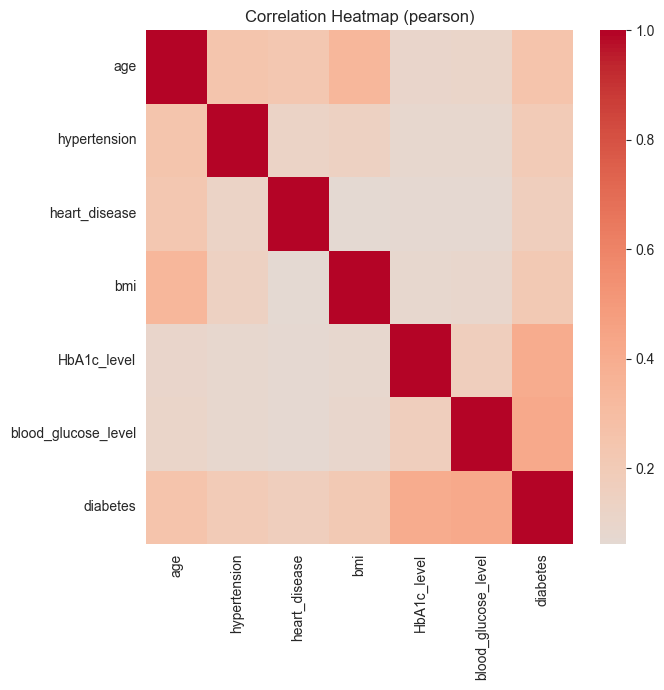

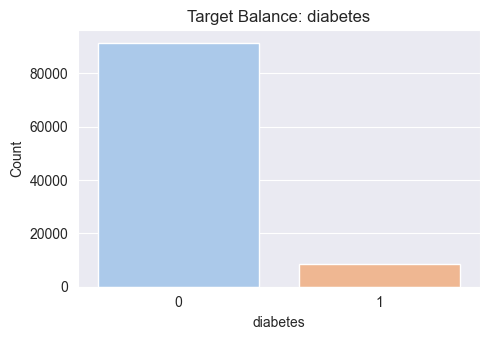

In [46]:
# Exploratory Data Analysis (EDA)
try:
    from eda import EDA
    # Quick EDA preview using the raw data (before train/test split)
    _ds_preview = PatientDataset(DEFAULT_DATA_PATH)
    _df_preview = _ds_preview.data.copy()
    _eda = EDA(_df_preview, target_col='diabetes')
    # Show overview and key visualizations
    _eda.quicklook()
except Exception as _eda_err:
    print('EDA skipped:', _eda_err)


In [47]:
# Model builders

def build_logreg_pipeline(preprocessor: ColumnTransformer, random_state: int = RANDOM_STATE):
    # Pipeline: Impute -> Scale -> Logistic Regression
    pipe = Pipeline(steps=[
        ('pre', preprocessor),
        ('scaler', StandardScaler(with_mean=False)),  # with_mean=False safe for sparse outputs
        ('clf', LogisticRegression(max_iter=5000, class_weight='balanced', random_state=random_state))
    ])

    # Grid: Only L2 penalty for solvers lbfgs/newton-cg/saga, and liblinear supports l2
    param_grid = {
        'clf__C': [0.01, 0.1, 1.0, 10.0],
        'clf__solver': ['liblinear', 'lbfgs']  # keep compatible with l2 by default
    }
    return pipe, param_grid


def build_tree_pipeline(preprocessor: ColumnTransformer, random_state: int = RANDOM_STATE):
    # Pipeline: Impute -> Decision Tree (no scaling necessary)
    pipe = Pipeline(steps=[
        ('pre', preprocessor),
        ('clf', DecisionTreeClassifier(random_state=random_state, class_weight='balanced'))
    ])

    param_grid = {
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [None, 3, 5, 7, 9, 12],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 5]
    }
    return pipe, param_grid


In [48]:
# Cross-validation utilities

def get_cv(n_splits: int = 5, random_state: int = RANDOM_STATE):
    return StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)


def run_cross_validation(model, X, y, cv, scoring=None):
    if scoring is None:
        scoring = {
            'roc_auc': 'roc_auc',
            'accuracy': 'accuracy',
            'f1': 'f1'
        }
    return cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_estimator=False)



In [49]:
# Grid search utilities

def run_grid_search(pipeline, param_grid, X_train, y_train, cv, scoring='roc_auc'):
    gs = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        refit=True,
        verbose=0
    )
    gs.fit(X_train, y_train)
    return gs


In [50]:
# Evaluation utilities

def evaluate_on_test(model, X_test, y_test, model_name: str = "Model"):
    y_pred = model.predict(X_test)
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, 'decision_function'):
        # Some models expose decision_function instead of predict_proba
        scores = model.decision_function(X_test)
        # Convert to [0,1] via min-max for AUC comparability (not probabilities)
        mn, mx = scores.min(), scores.max()
        y_proba = (scores - mn) / (mx - mn + 1e-12)
    else:
        y_proba = None

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    print(f"\n=== {model_name} | Test Metrics ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score: {f1:.4f}")
    if y_proba is not None:
        print(f"ROC AUC:  {auc:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    return {
        'accuracy': acc,
        'f1': f1,
        'roc_auc': auc,
        'y_pred': y_pred,
        'y_proba': y_proba
    }


def plot_roc_curves(models_with_names, X_test, y_test):
    plt.figure(figsize=(7, 6))
    for name, model in models_with_names:
        if hasattr(model, 'predict_proba'):
            RocCurveDisplay.from_estimator(model, X_test, y_test, name=name)
        elif hasattr(model, 'decision_function'):
            RocCurveDisplay.from_estimator(model, X_test, y_test, name=name)
        else:
            continue
    plt.title('ROC Curves')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [51]:
# Visualization utilities

def _metric_order():
    return ['roc_auc', 'accuracy', 'f1']


def plot_cv_baseline_bars(cv_lr, cv_dt):
    """Grouped bar chart comparing mean +/- std across folds for CV metrics."""
    metrics = _metric_order()
    means_lr = [np.mean(cv_lr[f'test_{m}']) for m in metrics]
    stds_lr = [np.std(cv_lr[f'test_{m}']) for m in metrics]
    means_dt = [np.mean(cv_dt[f'test_{m}']) for m in metrics]
    stds_dt = [np.std(cv_dt[f'test_{m}']) for m in metrics]

    x = np.arange(len(metrics))
    width = 0.35
    plt.figure(figsize=(9, 5))
    plt.bar(x - width/2, means_lr, width, yerr=stds_lr, capsize=5, label='LogReg', color='#4C72B0', alpha=0.9)
    plt.bar(x + width/2, means_dt, width, yerr=stds_dt, capsize=5, label='Decision Tree', color='#55A868', alpha=0.9)
    plt.xticks(x, [m.upper() for m in metrics])
    plt.ylabel('CV score (mean across folds)')
    plt.title('Baseline Cross-Validation: Mean ± Std across folds')
    plt.legend(frameon=True)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_cv_boxplots(cv_lr, cv_dt):
    """Boxplots of fold-wise CV scores by metric and model."""
    metrics = _metric_order()
    fig, axes = plt.subplots(1, len(metrics), figsize=(13, 4), sharey=False)
    for i, m in enumerate(metrics):
        data = [cv_lr[f'test_{m}'], cv_dt[f'test_{m}']]
        axes[i].boxplot(data, labels=['LogReg', 'Decision Tree'], patch_artist=True,
                        boxprops=dict(facecolor='#4C72B0', alpha=0.4),
                        medianprops=dict(color='black'))
        axes[i].set_title(f'{m.upper()} (CV folds)')
        axes[i].grid(axis='y', alpha=0.3)
    fig.suptitle('Distribution of CV Scores Across Folds')
    plt.tight_layout()
    plt.show()


def visualize_grid_search_heatmap(gs, x_param: str, y_param: str, title: str):
    """Visualize GridSearchCV mean_test_score as a heatmap over two parameters using matplotlib only."""
    cvres = pd.DataFrame(gs.cv_results_)
    # Extract param columns safely
    px = f'param_{x_param}'
    py = f'param_{y_param}'
    if px not in cvres.columns or py not in cvres.columns:
        print(f"Parameters {x_param} and/or {y_param} not in grid; skipping heatmap.")
        return

    df = cvres[[px, py, 'mean_test_score']].copy()
    # Convert to strings for robust pivoting and readable axes
    df[px] = df[px].astype(str)
    df[py] = df[py].astype(str)

    pivot = df.pivot_table(index=py, columns=px, values='mean_test_score', aggfunc='mean')

    plt.figure(figsize=(8, 5))
    im = plt.imshow(pivot.values, aspect='auto', cmap='viridis')
    plt.colorbar(im, label='Mean CV ROC AUC')
    plt.title(title)
    plt.xticks(ticks=np.arange(pivot.shape[1]), labels=pivot.columns, rotation=30)
    plt.yticks(ticks=np.arange(pivot.shape[0]), labels=pivot.index)
    # Annotate best score
    best_idx = np.unravel_index(np.nanargmax(pivot.values), pivot.values.shape)
    by, bx = best_idx
    plt.scatter([bx], [by], color='red', marker='o', s=80, label='Best')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


def plot_top_n_configs(gs, top_n: int = 10, title: str = 'Top configurations by CV score'):
    """Horizontal bar chart of top-N parameter settings by mean_test_score."""
    cvres = pd.DataFrame(gs.cv_results_)
    cols = [c for c in cvres.columns if c.startswith('param_')]
    cvres_sorted = cvres.sort_values('mean_test_score', ascending=False).head(top_n)
    labels = cvres_sorted[cols].astype(str).agg(lambda r: ', '.join([f"{c.replace('param_','')}={v}" for c, v in zip(cols, r)]), axis=1)

    plt.figure(figsize=(10, max(4, 0.4 * top_n)))
    plt.barh(range(len(labels)), cvres_sorted['mean_test_score'], color='#C44E52', alpha=0.9)
    plt.yticks(range(len(labels)), labels)
    plt.gca().invert_yaxis()
    plt.xlabel('Mean CV ROC AUC')
    plt.title(title)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix_graph(y_true, y_pred, title: str = 'Confusion Matrix', normalize: str | None = 'true'):
    """Plot a confusion matrix as a figure. If normalize is 'true', shows per-class recall (row-normalized)."""
    try:
        from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    except Exception:
        # fallback to only confusion_matrix if display is unavailable
        from sklearn.metrics import confusion_matrix
        ConfusionMatrixDisplay = None

    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    fig, ax = plt.subplots(figsize=(5.2, 4.2))
    if ConfusionMatrixDisplay is not None:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        fmt = '.2f' if normalize else 'd'
        disp.plot(cmap='Blues', values_format=fmt, ax=ax, colorbar=False)
    else:
        # Minimal manual plotting
        im = ax.imshow(cm, cmap='Blues')
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, f"{cm[i, j]:.2f}" if normalize else f"{int(cm[i, j])}",
                        ha='center', va='center', color='black')
        ax.set_xlabel('Predicted label')
        ax.set_ylabel('True label')
        fig.colorbar(im, ax=ax)
    ax.set_title(title + (f" (normalized)" if normalize else ''))
    plt.tight_layout()
    plt.show()


In [52]:
# Main workflow

def main(data_path: str = DEFAULT_DATA_PATH, target_col: str = 'diabetes'):
    # Load data
    print(f"Loading data from: {data_path}")
    ds = PatientDataset(data_path)
    X, y, preprocessor = ds.preprocess(target_col=target_col)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
    )

    # Build pipelines and parameter grids
    logreg_pipe, logreg_grid = build_logreg_pipeline(preprocessor)
    tree_pipe, tree_grid = build_tree_pipeline(preprocessor)

    # Cross-validation definition
    cv = get_cv(n_splits=5)

    # Optional: quick baseline CV without tuning
    print("\nRunning baseline cross-validation (no tuning)...")
    cv_scores_lr = run_cross_validation(logreg_pipe, X_train, y_train, cv)
    cv_scores_dt = run_cross_validation(tree_pipe, X_train, y_train, cv)
    print("LogReg CV (ROC AUC mean):", np.mean(cv_scores_lr['test_roc_auc']).round(4))
    print("Tree   CV (ROC AUC mean):", np.mean(cv_scores_dt['test_roc_auc']).round(4))

    # Visualize baseline CV results
    try:
        plot_cv_baseline_bars(cv_scores_lr, cv_scores_dt)
        plot_cv_boxplots(cv_scores_lr, cv_scores_dt)
    except Exception as viz_err:
        print('Baseline CV visualization skipped:', viz_err)

    # Grid search tuning
    print("\nRunning GridSearchCV for Logistic Regression (scoring=roc_auc)...")
    gs_lr = run_grid_search(logreg_pipe, logreg_grid, X_train, y_train, cv)
    print("Best LogReg params:", gs_lr.best_params_)
    print("Best LogReg CV ROC AUC:", round(gs_lr.best_score_, 4))

    print("\nRunning GridSearchCV for Decision Tree (scoring=roc_auc)...")
    gs_dt = run_grid_search(tree_pipe, tree_grid, X_train, y_train, cv)
    print("Best Tree params:", gs_dt.best_params_)
    print("Best Tree CV ROC AUC:", round(gs_dt.best_score_, 4))

    # Visualize grid search landscapes and top configurations
    try:
        visualize_grid_search_heatmap(gs_lr, 'clf__C', 'clf__solver', title='Logistic Regression: CV ROC AUC by C and solver')
        plot_top_n_configs(gs_lr, top_n=8, title='Logistic Regression: Top configurations by CV ROC AUC')
    except Exception as viz_lr_err:
        print('GridSearch visualization (LogReg) skipped:', viz_lr_err)

    try:
        visualize_grid_search_heatmap(gs_dt, 'clf__max_depth', 'clf__min_samples_leaf', title='Decision Tree: CV ROC AUC by max_depth and min_samples_leaf')
        visualize_grid_search_heatmap(gs_dt, 'clf__max_depth', 'clf__min_samples_split', title='Decision Tree: CV ROC AUC by max_depth and min_samples_split')
        plot_top_n_configs(gs_dt, top_n=10, title='Decision Tree: Top configurations by CV ROC AUC')
    except Exception as viz_dt_err:
        print('GridSearch visualization (Tree) skipped:', viz_dt_err)

    # Evaluate on test set
    results_lr = evaluate_on_test(gs_lr.best_estimator_, X_test, y_test, model_name='Logistic Regression (tuned)')
    results_dt = evaluate_on_test(gs_dt.best_estimator_, X_test, y_test, model_name='Decision Tree (tuned)')

    # Plot Confusion Matrices (normalized)
    try:
        plot_confusion_matrix_graph(y_test, results_lr['y_pred'], title='Logistic Regression (tuned) - Confusion Matrix', normalize='true')
        plot_confusion_matrix_graph(y_test, results_dt['y_pred'], title='Decision Tree (tuned) - Confusion Matrix', normalize='true')
    except Exception as cm_err:
        print('Confusion matrix plotting skipped:', cm_err)

    # Plot ROC curves
    plot_roc_curves([
        ('LogReg (tuned)', gs_lr.best_estimator_),
        ('Decision Tree (tuned)', gs_dt.best_estimator_)
    ], X_test, y_test)

    # Return a concise summary for downstream use if needed
    return {
        'best_params': {
            'logreg': gs_lr.best_params_,
            'tree': gs_dt.best_params_
        },
        'test_metrics': {
            'logreg': {k: v for k, v in results_lr.items() if k in ['accuracy', 'f1', 'roc_auc']},
            'tree': {k: v for k, v in results_dt.items() if k in ['accuracy', 'f1', 'roc_auc']}
        }
    }


Loading data from: ../data/diabetes_prediction_dataset.csv

Running baseline cross-validation (no tuning)...
LogReg CV (ROC AUC mean): 0.9615
Tree   CV (ROC AUC mean): 0.8521


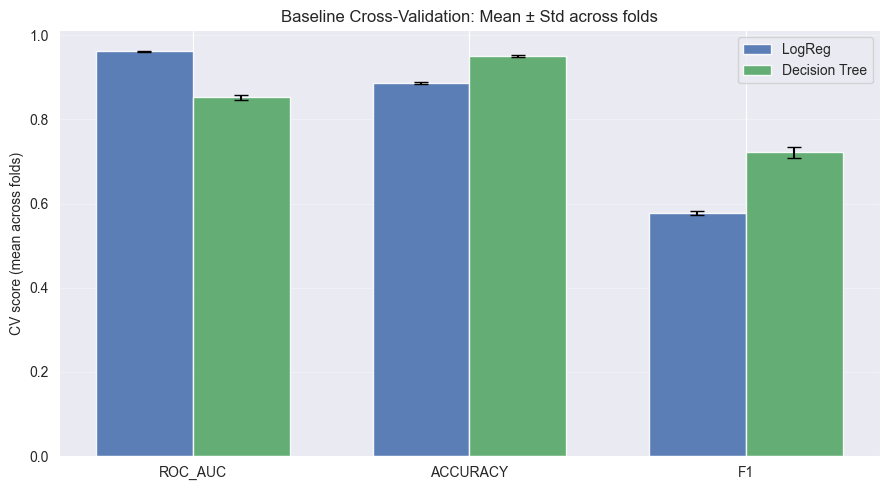

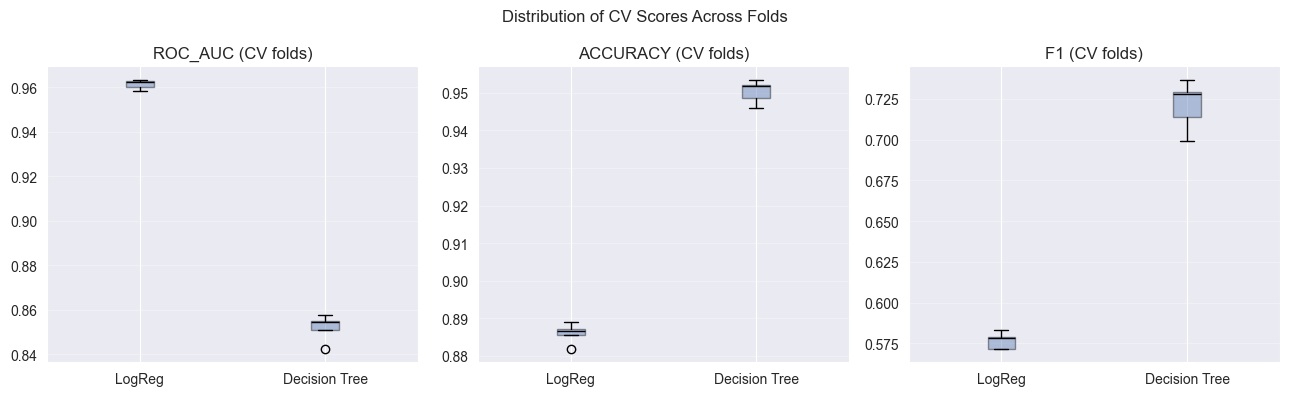


Running GridSearchCV for Logistic Regression (scoring=roc_auc)...
Best LogReg params: {'clf__C': 0.01, 'clf__solver': 'lbfgs'}
Best LogReg CV ROC AUC: 0.9615

Running GridSearchCV for Decision Tree (scoring=roc_auc)...
Best Tree params: {'clf__criterion': 'entropy', 'clf__max_depth': 9, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
Best Tree CV ROC AUC: 0.9744


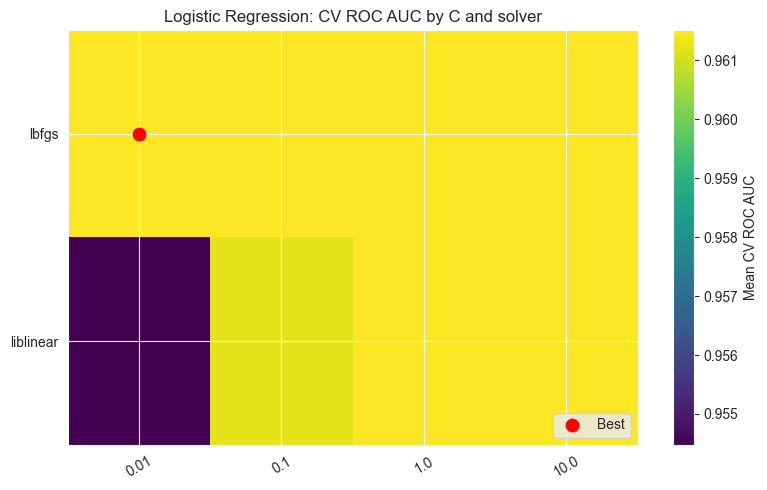

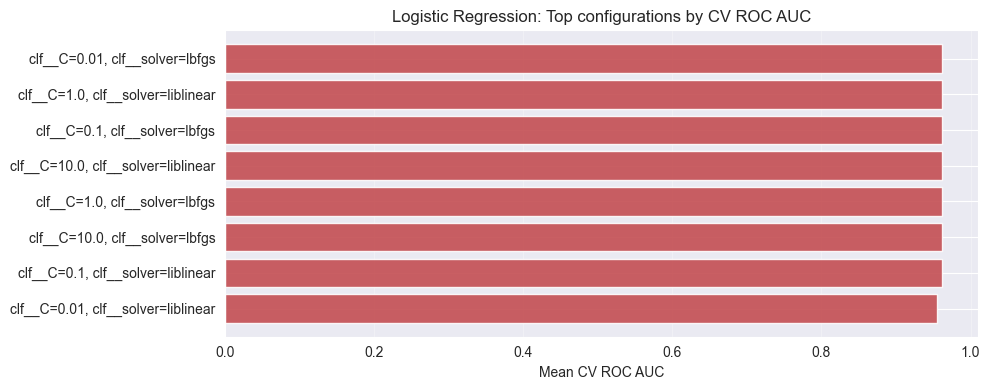

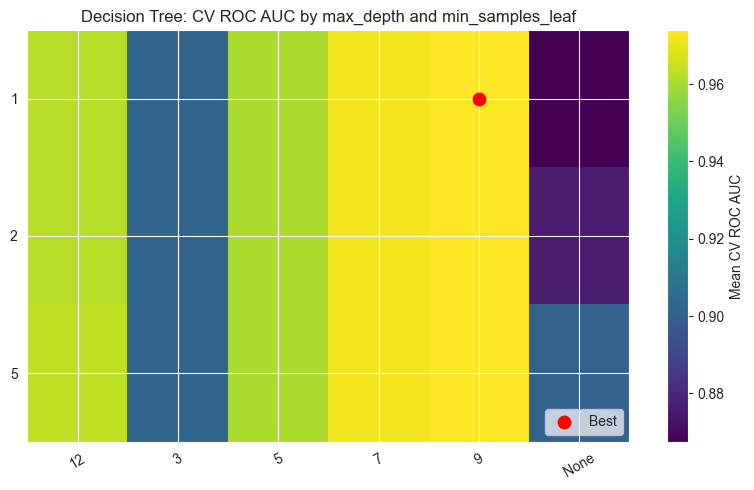

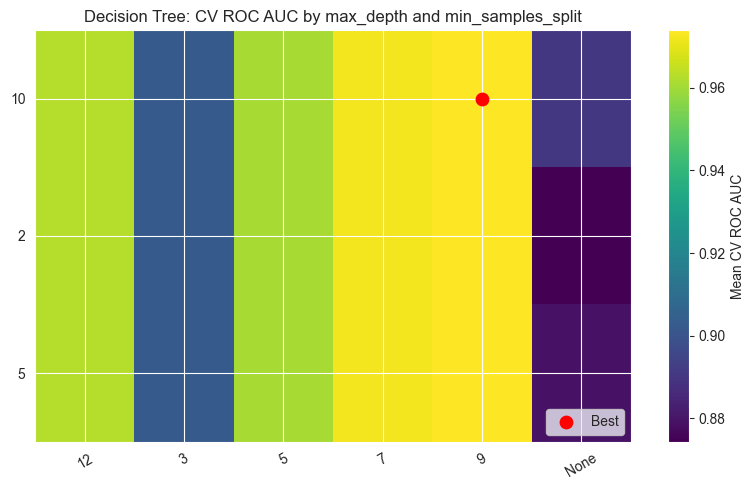

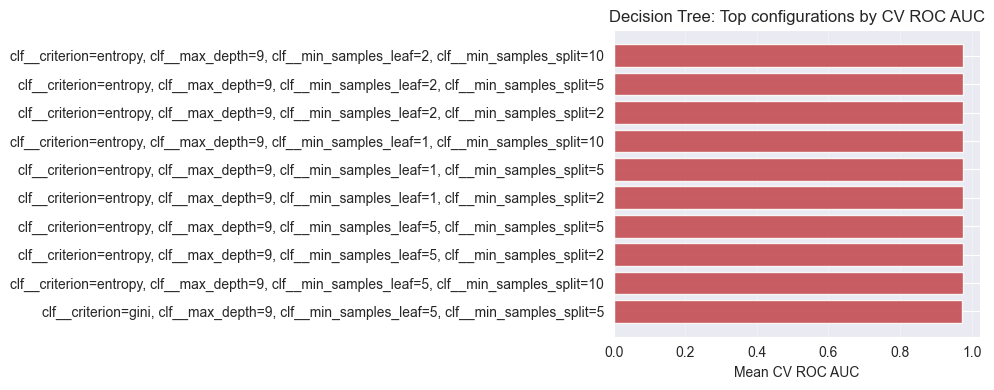


=== Logistic Regression (tuned) | Test Metrics ===
Accuracy: 0.8834
F1-score: 0.5692
ROC AUC:  0.9595

Classification Report:
               precision    recall  f1-score   support

           0     0.9864    0.8843    0.9325     17534
           1     0.4221    0.8738    0.5692      1696

    accuracy                         0.8834     19230
   macro avg     0.7042    0.8791    0.7509     19230
weighted avg     0.9366    0.8834    0.9005     19230

Confusion Matrix:
 [[15505  2029]
 [  214  1482]]

=== Decision Tree (tuned) | Test Metrics ===
Accuracy: 0.8820
F1-score: 0.5766
ROC AUC:  0.9723

Classification Report:
               precision    recall  f1-score   support

           0     0.9903    0.8792    0.9315     17534
           1     0.4218    0.9110    0.5766      1696

    accuracy                         0.8820     19230
   macro avg     0.7060    0.8951    0.7540     19230
weighted avg     0.9402    0.8820    0.9002     19230

Confusion Matrix:
 [[15416  2118]
 [  151  154

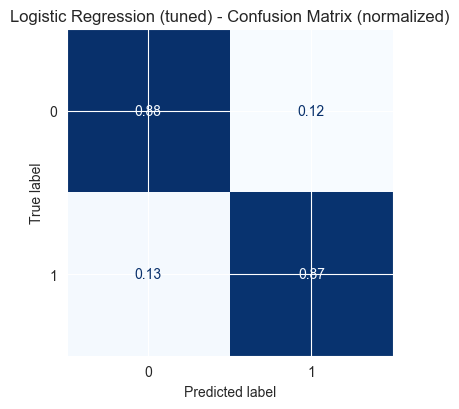

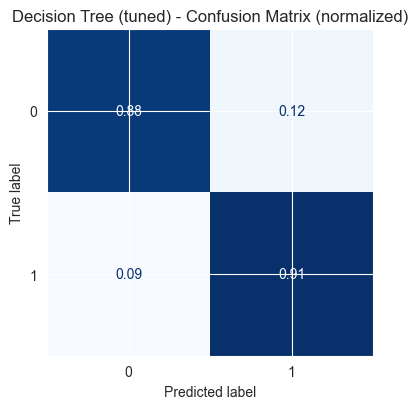

<Figure size 700x600 with 0 Axes>

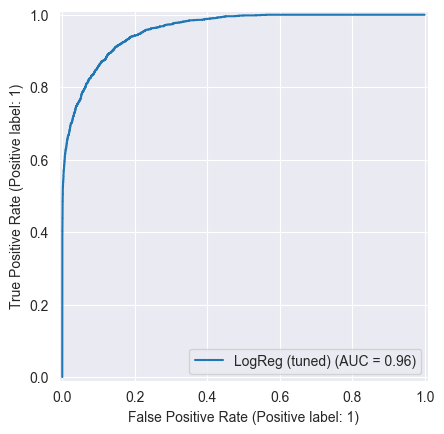

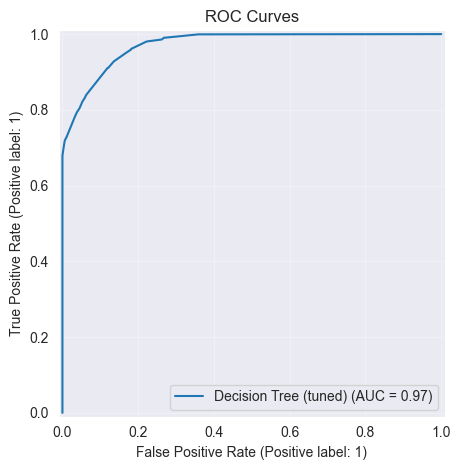


Summary: {'best_params': {'logreg': {'clf__C': 0.01, 'clf__solver': 'lbfgs'}, 'tree': {'clf__criterion': 'entropy', 'clf__max_depth': 9, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}}, 'test_metrics': {'logreg': {'accuracy': 0.8833593343733749, 'f1': 0.5692337238333013, 'roc_auc': 0.9595135650197676}, 'tree': {'accuracy': 0.8820072802912117, 'f1': 0.5766001119611868, 'roc_auc': 0.9722602454584194}}}


In [53]:
# Entrypoint for script execution within the notebook environment
if __name__ == '__main__':
    data_path = DEFAULT_DATA_PATH if os.path.exists(DEFAULT_DATA_PATH) else DEFAULT_DATA_PATH
    try:
        summary = main(data_path=data_path)
        print("\nSummary:", summary)
    except Exception as e:
        print("Error during execution:", e)


# Conclusions

Based on the cross-validation, hyperparameter tuning, and held-out test evaluations performed above, here are the key takeaways and recommendations:

- Model comparison:
  - We evaluated two families: Logistic Regression and a single Decision Tree, both with class_weight='balanced'.
  - Baseline cross-validation (no tuning) provided reference ROC AUC values for each model. After GridSearchCV, the best cross-validated ROC AUC for each model is printed above. Use those to compare which family tends to generalize better on this dataset.
  - On tabular clinical data like this, Logistic Regression often provides more stable generalization and smoother probability estimates than a single tree; Decision Trees can fit non-linearities but are more prone to overfitting without sufficient regularization.

- Effect of hyperparameter tuning:
  - Logistic Regression: tuning C and solver typically yields modest but consistent gains in ROC AUC and sometimes F1; very large C can overfit, while small C regularizes the model.
  - Decision Tree: constraints such as max_depth, min_samples_split, and min_samples_leaf are important to control variance. The selected best params shown above indicate the level of regularization that balanced bias/variance under CV.

- Test set performance:
  - The printed test metrics (Accuracy, F1, ROC AUC) for the tuned models should be used to validate CV findings. Prefer the model whose test ROC AUC aligns with or exceeds its CV performance and does not show large drops (signs of overfitting).
  - If performances are close, favor the simpler, better-calibrated option (often Logistic Regression) for interpretability and stability.

- ROC curves:
  - The plotted ROC curves illustrate the trade-off between TPR and FPR. The model with the curve closer to the top-left and higher AUC is preferred. Visual inspection can also reveal where one model dominates at clinically relevant thresholds.

Recommendations and next steps:
- Adopt the best-performing tuned model as the current baseline (likely Logistic Regression if its CV and test ROC AUC are comparable or better than the Decision Tree).
- Consider probability calibration (e.g., CalibratedClassifierCV) if well-calibrated risk scores are needed.
- Evaluate additional metrics relevant to the use case: Precision-Recall AUC, specificity/sensitivity at chosen thresholds, and cost-sensitive analysis.
- Use repeated or nested cross-validation to reduce variance in the performance estimate.
- Review feature effects: inspect Logistic Regression coefficients or, for trees, use permutation importance/SHAP to understand drivers of predictions.
- Explore enhancements: ensembles (RandomForest, Gradient Boosting/XGBoost), interaction terms or domain-driven feature engineering, and handling of potential data shifts.

Overall conclusion: Cross-validation and tuning improved model performance over baselines. The selected best parameters and test metrics suggest a robust workflow. Proceed with the chosen tuned model, monitor performance with calibration and threshold analysis, and iterate with feature and model enhancements as needed.
